In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
df_trainval = pd.read_csv("./development.csv")
df_test = pd.read_csv("./evaluation.csv")

## Preprocessing

We see the presence of a na in both title and article. if they are from the same id we can remove the all row altogether, otherwise it may still contain valuable information and we only replace the missing column with an empty string

In [3]:
df_trainval.values[np.argmax(df_trainval['title'].isna()),:]


array([26038, 'Forbes', nan, '\\N', 5, '2004-11-19 23:47:53', 1],
      dtype=object)

no title but not article either, i can drop it

In [4]:
df_trainval['title'].dropna(inplace=True)

no article but still a title, i can use it

In [5]:
df_trainval.values[np.argmax(df_trainval['article'].isna()),:]
df_trainval['article'].fillna('',inplace=True)

/tmp/ipykernel_49260/1246389770.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_trainval['article'].fillna('',inplace=True)


Drop duplicates, casefold, strip spaces, links and other crap

In [6]:
df_trainval['title'].str.casefold().str.strip()
df_trainval['article'].str.casefold().str.strip()

df_trainval.drop_duplicates(subset = 'article', inplace=True)

X_trainval = df_trainval['title'] + ' ' + df_trainval['title'] + ' ' + df_trainval['article']
y_trainval = df_trainval['label']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
  X_trainval,
  y_trainval,
  test_size= .2,
  random_state=42,
  stratify=y_trainval
)

it is necessary to stratify over y since classes are not evenly distributed

<BarContainer object of 7 artists>

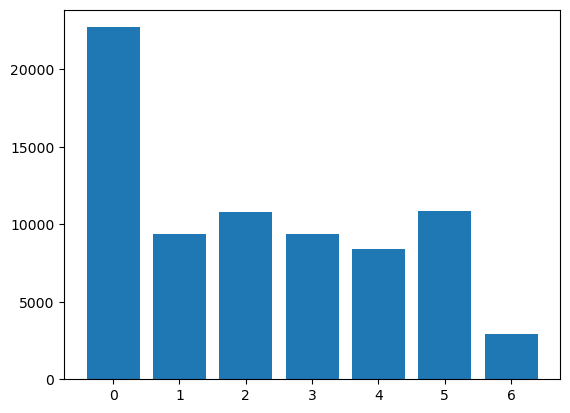

In [8]:
from collections import Counter

plt.bar(Counter(y_trainval).keys(),Counter(y_trainval).values())

In [9]:
pipe = Pipeline([
  ('tfidf', TfidfVectorizer()),
  ('clf', LogisticRegression(max_iter=3000, class_weight='balanced'))
])

parameter_space = {
  'tfidf__ngram_range': [ (1, 2), (1,3), (1,4), (1,5),(1,6)],
  'tfidf__max_df': [0.5],
  'tfidf__min_df': [1],
  'tfidf__max_features': [20000],

  'clf__C': [1],
  'clf__solver': ['saga'],
        }
grid_search = GridSearchCV(
  pipe,
  parameter_space,
  cv = 2,
  n_jobs = 7,
  verbose = 3,
  scoring="f1_macro"
)
grid_search.fit(X_train,y_train)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END clf__C=1, clf__solver=saga, tfidf__max_df=0.5, tfidf__max_features=20000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.649 total time= 1.3min
[CV 1/2] END clf__C=1, clf__solver=saga, tfidf__max_df=0.5, tfidf__max_features=20000, tfidf__min_df=1, tfidf__ngram_range=(1, 3);, score=0.652 total time= 1.5min
[CV 1/2] END clf__C=1, clf__solver=saga, tfidf__max_df=0.5, tfidf__max_features=20000, tfidf__min_df=1, tfidf__ngram_range=(1, 4);, score=0.653 total time= 1.7min
[CV 1/2] END clf__C=1, clf__solver=saga, tfidf__max_df=0.5, tfidf__max_features=20000, tfidf__min_df=1, tfidf__ngram_range=(1, 5);, score=0.655 total time= 1.9min
[CV 1/2] END clf__C=1, clf__solver=saga, tfidf__max_df=0.5, tfidf__max_features=20000, tfidf__min_df=1, tfidf__ngram_range=(1, 6);, score=0.654 total time= 1.8min


/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END clf__C=1, clf__solver=saga, tfidf__max_df=0.5, tfidf__max_features=20000, tfidf__min_df=1, tfidf__ngram_range=(1, 3);, score=0.652 total time= 8.8min


/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END clf__C=1, clf__solver=saga, tfidf__max_df=0.5, tfidf__max_features=20000, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.651 total time= 8.9min


/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END clf__C=1, clf__solver=saga, tfidf__max_df=0.5, tfidf__max_features=20000, tfidf__min_df=1, tfidf__ngram_range=(1, 4);, score=0.653 total time= 9.7min


/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END clf__C=1, clf__solver=saga, tfidf__max_df=0.5, tfidf__max_features=20000, tfidf__min_df=1, tfidf__ngram_range=(1, 5);, score=0.654 total time= 9.1min


/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2] END clf__C=1, clf__solver=saga, tfidf__max_df=0.5, tfidf__max_features=20000, tfidf__min_df=1, tfidf__ngram_range=(1, 6);, score=0.655 total time= 9.0min


/usr/lib/python3/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=3000))]),
             n_jobs=7,
             param_grid={'clf__C': [1], 'clf__solver': ['saga'],
                         'tfidf__max_df': [0.5], 'tfidf__max_features': [20000],
                         'tfidf__min_df': [1],
                         'tfidf__ngram_range': [(1, 2), (1, 3), (1, 4), (1, 5),
                                                (1, 6)]},
             scoring='f1_macro', verbose=3)

In [10]:
print(grid_search.best_score_, grid_search.best_params_)
'''0.6434420025731791 {'clf__C': 1, 'clf__solver': 'saga', 'tfidf__max_df': 0.5, 'tfidf__max_features': 10000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}'''


0.6545033843649364 {'clf__C': 1, 'clf__solver': 'saga', 'tfidf__max_df': 0.5, 'tfidf__max_features': 20000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 6)}


"0.6434420025731791 {'clf__C': 1, 'clf__solver': 'saga', 'tfidf__max_df': 0.5, 'tfidf__max_features': 10000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}"

In [11]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
print(f1_score(y_val, y_pred, average='macro'))

0.6641361966932714


In [12]:
df_test['title'].str.casefold().str.strip()
df_test['article'].str.casefold().str.strip()
df_test.fillna('', inplace=True)
X_test = df_test['title'] + ' ' + df_test['title'] + ' ' + df_test['article']
X_test

0        Radio appeal unearths missing pickle recipe Ra...
1        Vonage loses appeal in Verizon patent case Von...
2        Italy launches major offensive against organiz...
3        BAE 'to appoint ethics committee' BAE 'to appo...
4        US envoy Bolton to stop here on way to nuclear...
                               ...                        
19995    Hurricane Lane Roars Toward Baja Hurricane Lan...
19996    Broncosâ Griffin reportedly out for season B...
19997    `Catwoman` Halle draws no purrs from Gwyneth `...
19998    Five British soldiers cleared over mistreating...
19999    Italy&#39;s military presence in Iraq will con...
Length: 20000, dtype: object

In [13]:
submit = pd.DataFrame()
submit['Id'] = np.arange(len(df_test))
submit['Predicted'] = best_model.predict(X_test)
submit.to_csv('./submission.csv', sep=',', index=False)

In [14]:
y_pred = best_model.predict(X_train)
print(f1_score(y_train, y_pred, average='macro'))

0.7685956325433567
